In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading

In [2]:
import psycopg2
import pandas as pd

# Function to load data into a DataFrame
def load_data_to_dataframe():
    try:
        # Establish a connection to the PostgreSQL database
        connection = psycopg2.connect(
            host='10.10.10.10',  # Replace with your host
            port=5432,           # Default PostgreSQL port
            user='postgres',     # Replace with your username
            password='adm',      # Replace with your password
            database='adm'       # Replace with your database name
        )
        
        # Create a SQL query to retrieve 10,000 records
        # query = "SELECT body FROM reddit_2007 WHERE body != '[deleted]' and length(body) > 100 limit 30000;"
        query = "SELECT * FROM filtered LIMIT 100000;"

        # Load the data into a pandas DataFrame
        df = pd.read_sql_query(query, connection)

    except Exception as e:
        print("An error occurred:", e)

    finally:
        # Close the connection
        if connection:
            connection.close()
    
    return df

# Call the function to load data into a DataFrame
df = load_data_to_dataframe()

C:\Users\Marcin\AppData\Local\Temp\ipykernel_58980\1474581880.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [3]:
df = df[['body', 'subreddit']]

In [4]:
df.head()

,body,subreddit
0,"Ugh, tired of this argument, no one's asking t...",politics
1,Buy 2 get one free sales do happen as such it'...,gaming
2,"The writing is superior to Fallout 3, and afte...",gaming
3,I haven't shopped at a Walmart in over 8 years...,politics
4,&gt;I see you completely believed the story th...,politics


In [5]:
df.subreddit.value_counts()

subreddit
politics       45464
gaming         27087
technology     14851
science         8557
programming     4041
Name: count, dtype: int64

In [6]:
df = pd.concat([df[df['subreddit'] == subreddit].sample(1500, random_state=42)
               for subreddit in df['subreddit'].unique()]).reset_index(drop=True)
df['subreddit'].value_counts()

subreddit
politics       1500
gaming         1500
technology     1500
programming    1500
science        1500
Name: count, dtype: int64

# Data cleaning

In [7]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Ensure consistent language detection
DetectorFactory.seed = 0

# Function to check if a text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If detection fails, consider it non-English
    
print('Before filtering for English laguage: ', df.shape)

# Filter DataFrame to keep only English texts
df = df[df['body'].apply(is_english)]

print('After filtering for English laguage: ', df.shape)

Before filtering for English laguage:  (7500, 2)
After filtering for English laguage:  (7469, 2)


In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['body'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df['subreddit'].value_counts()

subreddit
politics       1500
science        1499
technology     1497
programming    1493
gaming         1480
Name: count, dtype: int64

# Bag of Words

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

bow_matrix = vectorizer.fit_transform(df['clean_text'])

X = bow_matrix.toarray()

feature_names = vectorizer.get_feature_names_out()

X.shape

(7469, 34051)

# TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=120)
X = vectorizer.fit_transform(df['clean_text']).toarray()

X.shape

(7469, 120)

# Hidden Markov Models classification

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['subreddit'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
from hmmlearn import hmm

def compute_transition_array(sequence):
    states = np.unique(sequence)
    n_states = len(states)
    M = np.zeros((n_states, n_states))
    for (i,j) in zip(sequence, sequence[1:]):
        M[i][j] += 1
    return M/M.sum(1).reshape(-1, 1)

def return_init_params(train_data, n_states, model = None):
    if model is None:
        gm = GaussianMixture(n_components=n_states)
    else:
        gm = GaussianMixture(
            n_components = n_states,
            means_init = model.means_,
            weights_init = model.startprob_,
            precisions_init = np.linalg.inv(model.covars_)
        )
        transmat = model.transmat_

    gm.fit(train_data)
    states = gm.predict(train_data)
    transmat = compute_transition_array(states)
    edge = gm.means_
    covs = gm.covariances_.diagonal(0, 1, 2)
    pda = gm.weights_/gm.weights_.sum()
    
    return transmat, covs, pda, edge, gm

In [21]:
n_states = 15

transmat_init, covars_init, startprob_init, means_init, gm = return_init_params(X_train, n_states)

model = hmm.GaussianHMM(
        n_components=n_states, 
        algorithm='viterbi', 
        covariance_type='diag',
)
        
model.init_params = ''
model.transmat_ = transmat_init
model.covars_ = covars_init
model.startprob_ = startprob_init
model.means_ = means_init

sequences = [sample.reshape(-1, 1) for sample in X_train]

all_sequences = np.vstack(sequences)  # Combine all samples into a single array
lengths = [len(seq) for seq in sequences]

model.fit(all_sequences, lengths)

GaussianHMM(init_params='', n_components=15)

In [22]:
states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_train]
states = np.vstack(states)
assert states.shape[0] == y_train.shape[0]

In [23]:
import xgboost as xgb

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=5,  # Number of classes in the dataset
    max_depth=10,  # Depth of the decision trees
    learning_rate=0.05,  # Learning rate for boosting steps
    n_estimators=100,  # Number of boosting rounds (trees)
)

In [24]:
states.shape

(5228, 120)

In [25]:
xgb_model = xgb_model.fit(states, y_train)

In [26]:
test_states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_test]
test_states = np.vstack(test_states)

In [27]:
y_pred = xgb_model.predict(test_states)

In [28]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5564
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       440
           1       0.47      0.47      0.47       478
           2       0.71      0.65      0.68       435
           3       0.45      0.60      0.51       451
           4       0.38      0.31      0.34       437

    accuracy                           0.56      2241
   macro avg       0.57      0.56      0.56      2241
weighted avg       0.57      0.56      0.56      2241



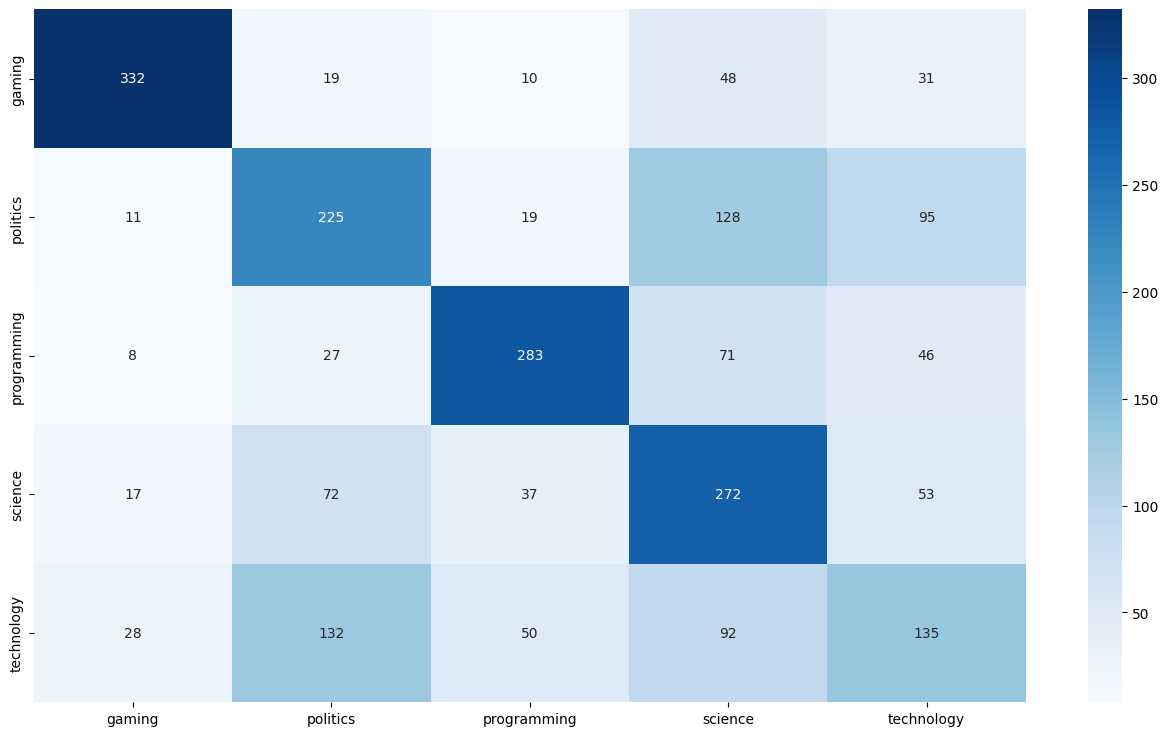

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/hmm_xgb_confusion_matrix.png')
plt.show()

In [34]:
label_encoder.classes_

array(['gaming', 'politics', 'programming', 'science', 'technology'],
      dtype=object)

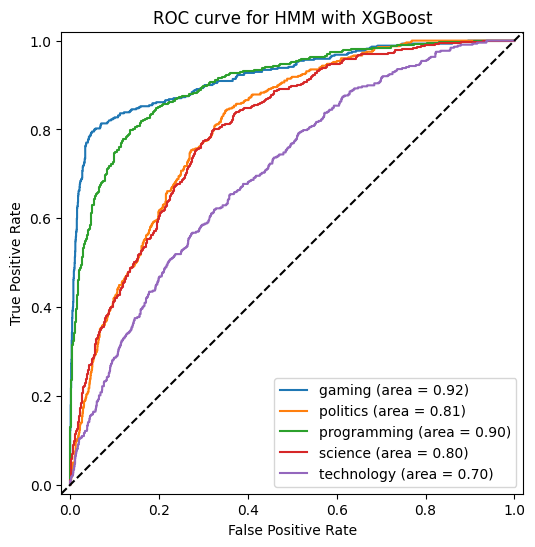

In [39]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

labels = label_encoder.classes_


y_score = xgb_model.predict_proba(test_states)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits,'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for HMM with XGBoost')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_hmm_xgboost.png', bbox_inches='tight')
plt.show()